In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [3]:
import os
import math
import time
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.utils import sample
from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig

In [4]:
def load_othello_model(ckpt):
    # original OthelloGPT params: n_layer=8, n_head=8, n_embd=512
    # vocab_size = 59, block_size = 61 for othello
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)
    model = GPT(mconf)
    load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt}.ckpt"))
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        model = model.to(device)
        return model, device
    else:
        print("NO GPU FOUND")

In [12]:
def draw_heatmap(token_pred):
    # take off first token, as it isn't a board position
    token_pred = token_pred[1:]
    # add padding to get from tokens -> board positions
    padding = np.zeros(2)
    board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
    # plotting
    fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8),
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

In [54]:
def quick_validate(model_ckpt, dataset):
    othello = Othello(data_root=dataset, n_games=1000, test_split=0, deduplicate=False)
    train_dataset = CharDataset(othello)
    loader = DataLoader(train_dataset, shuffle=False, pin_memory=True,
                                    batch_size=64,
                                    num_workers=0)

    model, device = load_othello_model(model_ckpt)

    # device = torch.cuda.current_device()
    stoi = np.vectorize(train_dataset.stoi.get) # othello move to token
    itos = np.vectorize(train_dataset.itos.get) # token to othello move

    total_nodes = 0
    success_nodes = 0
    def progress_report():
        return f"{success_nodes/total_nodes*100:.4f}% pass rate: {success_nodes}/{total_nodes} among all searched nodes"

    bar = tqdm(loader)
    for x, y in bar:
        # saving board positions for updating game state
        moves = x.numpy()
        moves = itos(moves)

        x = x.to(device)  # [B, T]
        y = y.to(device)  # [B, T]
        logits, loss = model(x, y)
        
        pred = torch.argmax(logits, dim=2).detach().cpu().numpy()
        # pred is [batch size, block_size (59 for normal othello setup)]
        # print(pred.shape)

        for game in range(pred.shape[0]):
            ob = OthelloBoardState()
            # print(moves[game])
            for i, m in enumerate(moves[game]):
                if m == -100:
                    break
                ob.update([m])
                valid = ob.get_valid_moves()
                if valid:
                    if train_dataset.itos[int(pred[game][i])] in valid:
                        success_nodes += 1
                    else:
                        # ob.__print__()
                        # print(valid)
                        # print(pred[game][i], permit_reverse(itos(pred[game][i])))
                        pass
                    total_nodes += 1   
            bar.set_description(progress_report())

    print(progress_report())

In [55]:
quick_validate("bias/TLcontrol", "othello_synthetic")

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.316 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


99.8439% pass rate: 58848/58940 among all searched nodes: 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]

99.8439% pass rate: 58848/58940 among all searched nodes


In [68]:
# calculating illegal probability share
othello = Othello(data_root="othello_TLbias80", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)
loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=0)

model, device = load_othello_model("bias/TLbias50")



Mem Used: 4.287 GB:   0%|          | 0/50 [00:00<?, ?it/s]


Loaded 100000 from 1 files
Using 1000 for training, 0 for validation
Dataset created has 1000 sequences, 61 unique words.


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:31<00:00,  1.99s/it]


<BarContainer object of 59 artists>

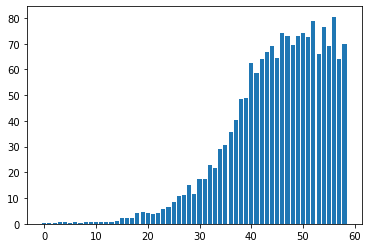

In [71]:
# device = torch.cuda.current_device()
stoi = np.vectorize(train_dataset.stoi.get) # othello move to token
itos = np.vectorize(train_dataset.itos.get) # token to othello move

batched_pred = np.zeros((59, 61))

for x, y in tqdm(loader):
    # saving board positions for updating game state
    moves = x.numpy()
    moves = itos(moves)

    x = x.to(device)  # [B, T]
    y = y.to(device)  # [B, T]
    logits, loss = model(x, y)
    
    logits = torch.softmax(logits, dim=2)
    pred = logits.detach().cpu().numpy()
    # pred is [batch size, block_size (59 for normal othello setup), vocab_size (61 for normal othello setup)]
    # print(pred.shape)

    legal_mask = np.zeros(pred.shape)
    for game in range(pred.shape[0]):
        ob = OthelloBoardState()
        # print(moves[game])
        for i, m in enumerate(moves[game]):
            if m == -100:
                break
            ob.update([m])
            valid = ob.get_valid_moves()
            if valid:
                legal_mask[game, i, stoi(valid)] = 1

    # legal_prob = pred * legal_mask
    illegal_prob = pred * (1 - legal_mask)

    np.add(batched_pred, illegal_prob.sum(axis=0), out=batched_pred)


# draw_heatmap(board_mass.sum(axis=0))

# move_mass = batched_pred.sum(axis=1)
# plt.bar(range(len(move_mass)), move_mass)

In [5]:
def calc_batched_pred(model_ckpt, dataset):
    othello = Othello(data_root=dataset, n_games=10000, test_split=0, deduplicate=False)
    train_dataset = CharDataset(othello)
    loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                    batch_size=64,
                                    num_workers=0)

    model, device = load_othello_model(model_ckpt)

    # device = torch.cuda.current_device()
    stoi = np.vectorize(train_dataset.stoi.get) # othello move to token
    itos = np.vectorize(train_dataset.itos.get) # token to othello move

    batched_pred = np.zeros((59, 61))

    for x, y in tqdm(loader):
        # saving board positions for updating game state
        moves = x.numpy()
        moves = itos(moves)

        x = x.to(device)  # [B, T]
        y = y.to(device)  # [B, T]
        logits, loss = model(x, y)
        
        logits = torch.softmax(logits, dim=2)
        pred = logits.detach().cpu().numpy()
        # pred is [batch size, block_size (59 for normal othello setup), vocab_size (61 for normal othello setup)]
        # print(pred.shape)

        legal_mask = np.zeros(pred.shape)
        for game in range(pred.shape[0]):
            ob = OthelloBoardState()
            # print(moves[game])
            for i, m in enumerate(moves[game]):
                if m == -100:
                    break
                ob.update([m])
                valid = ob.get_valid_moves()
                if valid:
                    legal_mask[game, i, stoi(valid)] = 1

        # legal_prob = pred * legal_mask
        illegal_prob = pred * (1 - legal_mask)

        np.add(batched_pred, illegal_prob.sum(axis=0), out=batched_pred)

    return batched_pred

In [ ]:
to_save = {}
for c in ["control", "bias50", "bias80", "bias95"]:
    for dr in ["synthetic", "TLbias50", "TLbias80", "TLbias95"]:
        print(f"======== ckpt: {c} | data: {dr} =========")
        arr = calc_batched_pred(f"bias/TL{c}", f"othello_{dr}")
        to_save[f"{c}_{dr}"] = arr
        

In [7]:
np.savez('illegal_move_mass.npz', **to_save)

In [ ]:
move_mass = [0 for _ in range(60)]

for game in tqdm(othello[:1000]):

    for len_partial_game in range(1, len(game)):
        partial = game[:len_partial_game]

        ob = OthelloBoardState()
        ob.update(partial)

        # load partial game onto GPU
        x = torch.tensor([train_dataset.stoi[s] for s in partial], dtype=torch.long).to(device)
        # get model prediction
        pred, _ = model(x[None, :]) 
        # transform to dict of move -> probability
        pred = pred[0, -1, :]
        pred = torch.softmax(pred, dim=0)
        move_pred = {train_dataset.itos[i] : float(p) for i,p in enumerate(pred)}

        legal_moves = ob.get_valid_moves()
        legal = [move_pred[m] for m in legal_moves]
        illegal = [move_pred[m] for m in move_pred.keys() if m not in legal_moves]

        legal_mass = sum(legal)
        illegal_mass = sum(illegal)

        move_mass[len_partial_game-1] += illegal_mass

print(move_mass)

<BarContainer object of 60 artists>

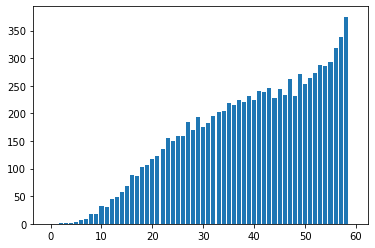

In [9]:
plt.bar(range(len(move_mass)), move_mass)

In [ ]:
othello = Othello(data_root="othello_TLbias50", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=0)

merged_pred = np.zeros((59, 61))
device = torch.cuda.current_device()
for x, y in loader:
    x = x.to(device)  # [B, T]
    y = y.to(device)  # [B, T]
    logits, loss = model(x, y)
    
    logits = torch.softmax(logits, dim=2)
    pred = logits.detach().cpu().numpy()
    # print(pred.shape)
    batch_pred = np.sum(pred, axis=0)
    np.add(merged_pred, batch_pred, out=merged_pred)

print(merged_pred.shape)



In [ ]:
# plotting heat maps of merged predictions

# for move in range(merged_pred.shape[0]):
for move in range(5):
    move_prob = merged_pred[move][1:]
    padding = np.zeros(2)
    board = np.concatenate([move_prob[:27], padding, move_prob[27:33], padding, move_prob[33:]], axis=0)
    # plotting
    fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), vmin=0, vmax=200,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

In [ ]:
# generates an animated gif of heatmaps over the course of the game

from PIL import Image

heatmap_images = []

for move in range(merged_pred.shape[0]):
    move_prob = merged_pred[move][1:]
    padding = np.zeros(2)
    board = np.concatenate([move_prob[:27], padding, move_prob[27:33], padding, move_prob[33:]], axis=0)
    
    fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), vmin=0, vmax=200,
                yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True,
                annot=True, fmt=".2f")
    
    # Convert the heatmap plot to an image
    fig.canvas.draw()
    heatmap_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    heatmap_images.append(heatmap_image)

heatmap_images[0].save('heatmap_animation.gif', save_all=True, append_images=heatmap_images[1:], loop=0)

## Visualizing Predictions

In [39]:
model, device = load_othello_model("bias/TLcontrol")

In [40]:
ex_games = Othello(data_root="othello_synthetic", n_games=5, test_split=1)
train_dataset = CharDataset(ex_games.val)

  0%|          | 0/50 [00:00<?, ?it/s]

Mem Used: 4.327 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 99999 from 1 files. Now deduplicating...
Deduplicating finished with 5 games left
Using 0 for training, 5 for validation
Dataset created has 5 sequences, 61 unique words.


In [18]:
# partial_game = ex_games.val[0][:7]
# partial_game = [19, 18, 17, 20, 21, 12, 37, 30, 14, 43, 26, 34, 39, 38, 46, 9, 42, 33, 4, 55, 32, 13, 44, 41, 0, 25, 3]
# partial_game = [19, 18, 17, 20, 21, 12, 37, 30, 14, 43, 26, 34, 39, 38, 46, 9, 42, 33, 4, 55, 32, 13, 44, 41, 0, 25]
partial_game = [19, 18, 17, 9, 1, 0, 26, 2, 10, 11, 3, 4, 8, 16, 37, 12, 5, 6, 13]
ob = OthelloBoardState()
ob.update(partial_game)
ob.__print__()
print([permit_reverse(x) for x in ob.get_valid_moves()])

--------------------
['c4', 'c3', 'c2', 'b2', 'a2', 'a1', 'd3', 'a3', 'b3', 'b4', 'a4', 'a5', 'b1', 'c1', 'e6', 'b5', 'a6', 'a7', 'b6']
a O O O O O O O  
b O O O O O O    
c O X X X        
d     X X X      
e       X X X    
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
['c5', 'd1', 'd2', 'e2', 'e3', 'f4', 'f5', 'f6', 'f7']


In [19]:
# load partial game onto GPU
history = torch.tensor([train_dataset.stoi[s] for s in partial_game], dtype=torch.long).to(device)
# get model prediction
pred, _ = model(history[None, :]) 
# transform into probability for each board state
pred = pred[0, -1, 1:]
padding = torch.zeros(2).cuda()
pred = torch.softmax(pred, dim=0)
pred = torch.cat([pred[:27], padding, pred[27:33], padding, pred[33:]], dim=0)

<AxesSubplot:>

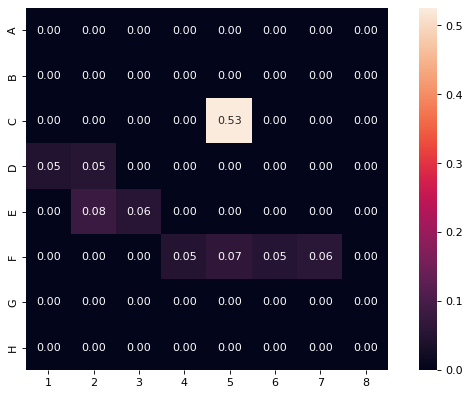

In [20]:
# plotting
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(pred.detach().cpu().numpy().reshape(8, 8), 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

In [10]:
raw = np.load("visuals/data/illegal_move_mass.npz")

data = {}
for k,v in raw.items():
    model, dataset = k.split("_")
    if model not in data:
        data[model] = {}
    data[model][dataset] = v.sum(axis=0)


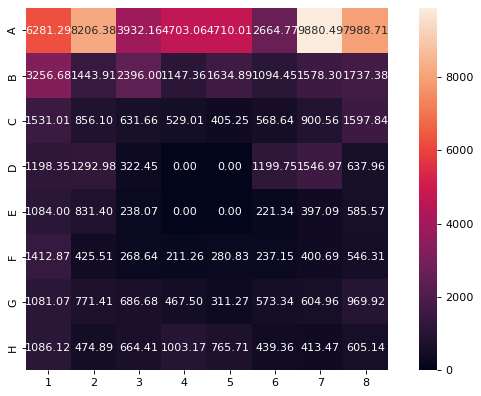

In [23]:
draw_heatmap(data["bias80"]["synthetic"])

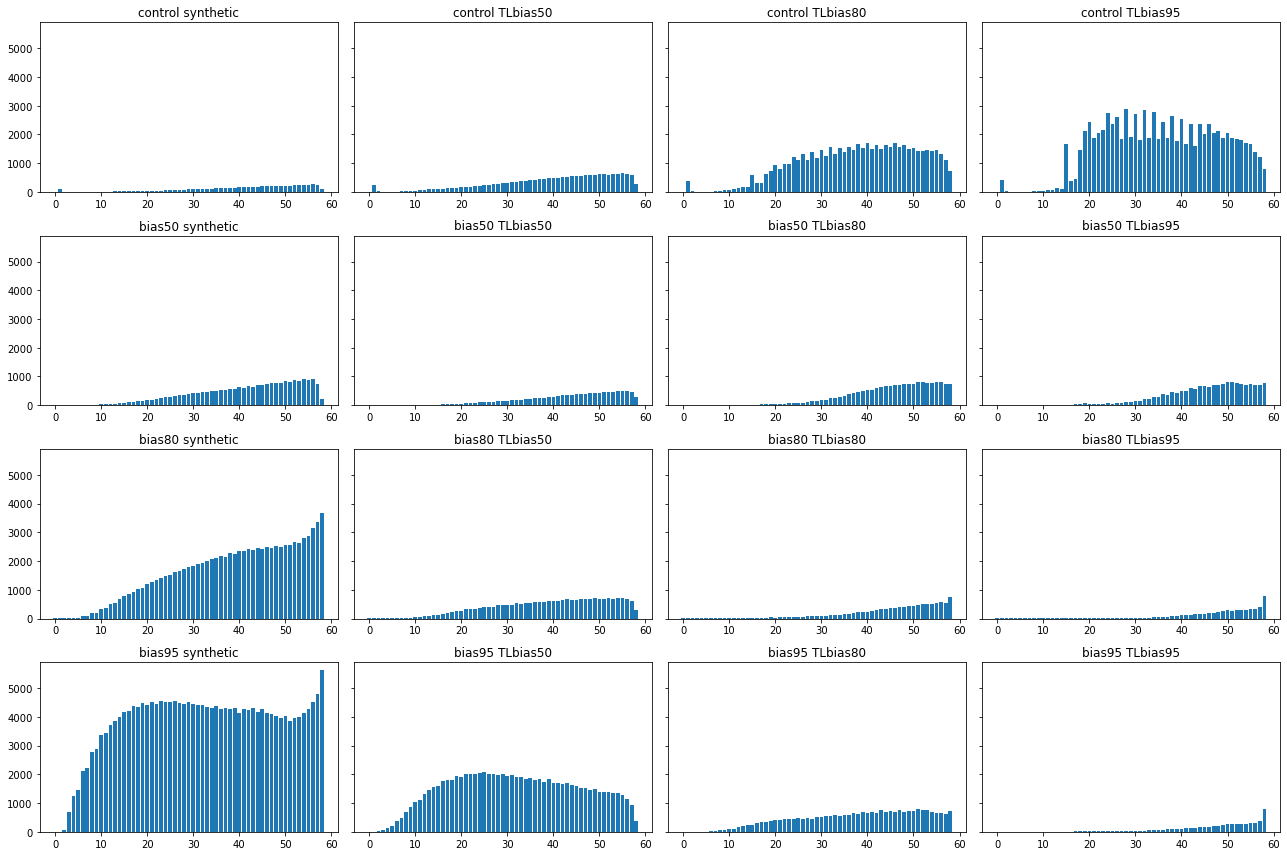

In [9]:
# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(18, 12), sharey=True)

# Iterate over each subplot
for i, model_name in enumerate(data):
    for j, dataset_name in enumerate(data[model_name]):
        y = data[model_name][dataset_name]
        # Plot the bar chart for each subplot
        axs[i, j].bar(range(len(y)), y)
        axs[i, j].set_title(f"{model_name} {dataset_name}")

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()